In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Example of CNN

In [3]:
class Net(nn.Module):
    '''
    Custom neural network class to implement CNN topology
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        x = torch.exp(x)
        return x
        
#     def num_flat_features(self, x):
#         size = x.size()[1:]
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features

In [161]:
net = Net()
print('My CNN: ', net)
params = list(net.parameters())
print('Num of parameter sets: ', len(params))
for i, param in enumerate(params):
    print('Num of parameters in set {}: {}'.format(i + 1, params[i].size()))

My CNN:  Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Num of parameter sets:  10
Num of parameters in set 1: torch.Size([6, 1, 3, 3])
Num of parameters in set 2: torch.Size([6])
Num of parameters in set 3: torch.Size([16, 6, 3, 3])
Num of parameters in set 4: torch.Size([16])
Num of parameters in set 5: torch.Size([120, 576])
Num of parameters in set 6: torch.Size([120])
Num of parameters in set 7: torch.Size([84, 120])
Num of parameters in set 8: torch.Size([84])
Num of parameters in set 9: torch.Size([10, 84])
Num of parameters in set 10: torch.Size([10])


In [179]:
img_in = torch.randn(1, 1, 32, 32)
out = net(img_in)
print(out, 'argmax={}'.format(out.argmax()))
net.zero_grad()
out.backward(torch.rand(1, 10))

tensor([[0.1096, 0.0982, 0.1040, 0.0885, 0.1058, 0.0979, 0.1051, 0.0985, 0.0892,
         0.1032]], grad_fn=<ExpBackward>) argmax=0


In [204]:
optimizer = optim.Adam(params=params, lr=0.01)

### to set zero grad before every backward/update loop
optimizer.zero_grad()

output = net(img_in)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0])
net.zero_grad()
print('conv1.bias.grad before backward:', net.conv1.bias.grad)
loss.backward()
print('conv1.bias.grad after backward:', net.conv1.bias.grad)

print('net params before optim:', params[0][0])

optimizer.step()

print('net params after optim:', params[0][0])

tensor(0.9224, grad_fn=<MseLossBackward>)
conv1.bias.grad before backward: tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward: tensor([-0.0072,  0.0012, -0.0001,  0.0004,  0.0315,  0.0117])
net params before optim: tensor([[[-0.1985, -0.2148, -0.0689],
         [ 0.0532, -0.1667, -0.2425],
         [ 0.2091,  0.1966,  0.2953]]], grad_fn=<SelectBackward>)
net params after optim: tensor([[[-0.1885, -0.2048, -0.0589],
         [ 0.0432, -0.1567, -0.2326],
         [ 0.2191,  0.1866,  0.2853]]], grad_fn=<SelectBackward>)


# Example CNN with Real Dataset

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

### Set download=True for trainset and testset below if using dataset does not exist in local
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

97.0%

Files already downloaded and verified


In [7]:
### Helper function to display image from torchvision
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

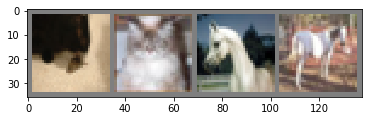

  cat   cat horse horse


In [18]:
dataiter = iter(trainloader)
# each iter of trainloader is 4 images, 4 labels
# each image in images is a 3 X 32 X 32 tensor
# each label is a 1 X 4 tensor, int type, corresponding to classes position above
images, labels = dataiter.next()

# make_grid makes an image arranged by (3 RGB Chans, H, W)
# to transpose data to imshow standard of (H, W, 3 RGB Chans)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [44]:
### Define net & net params ###
net = Net()
params = list(net.parameters())

### Set loss to be backpropagated for gradient calc, & optimizer to be used for latter ###
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=params, lr=0.001)

In [46]:
%%time
### Iterate over n (=2) epochs
for epoch in range(2):
    ### Instantiate loss for epoch session 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ### 4 inputs & labels at a time
        inputs, labels = data
        
        ### reset optimizer to zero
        optimizer.zero_grad()
        
        ### predict outputs using net
        outputs = net(inputs)
        
        ### calculate loss
        loss = criterion(outputs, labels)
        
        ### backpropagate and get gradient
        loss.backward()
        
        ### optimizer to update its params with gradient (dloss/dparams) with which it was instantiated with
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished training')

[1,  2000] loss: 1.904
[1,  4000] loss: 1.633
[1,  6000] loss: 1.540
[1,  8000] loss: 1.473
[1, 10000] loss: 1.431
[1, 12000] loss: 1.416
[2,  2000] loss: 1.329
[2,  4000] loss: 1.301
[2,  6000] loss: 1.306
[2,  8000] loss: 1.282
[2, 10000] loss: 1.258
[2, 12000] loss: 1.272
Finished training
Wall time: 5min 31s


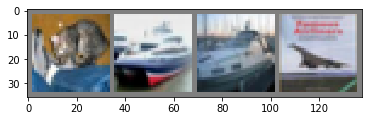

  cat,  ship,  ship, plane


In [47]:
### Load & Visualize test data
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(', '.join('%5s' % classes[labels[j]] for j in range(4)))

In [48]:
### Try on first set of 4 images
_, predictions = torch.max(net(images), 1)
print(', '.join('%5s' % classes[predictions[j]] for j in range(4)))

  cat,  ship, plane,  ship


In [49]:
correct = 0
total = 0

## To be fast, since only predicting, dont store gradients
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        
print('Accuracy of network: %d %%' % (100 * correct / total))

Accuracy of network: 55 %


# With GPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
### Define net & net params ###
net = Net()
net.to(device)
params = list(net.parameters())

### Set loss to be backpropagated for gradient calc, & optimizer to be used for latter ###
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=params, lr=0.001)

In [9]:
%%time
### Iterate over n (=2) epochs
for epoch in range(2):
    ### Instantiate loss for epoch session 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        ### 4 inputs & labels at a time
        inputs, labels = data[0].to(device), data[1].to(device)
        
        ### reset optimizer to zero
        optimizer.zero_grad()
        
        ### predict outputs using net
        outputs = net(inputs)
        
        ### calculate loss
        loss = criterion(outputs, labels)
        
        ### backpropagate and get gradient
        loss.backward()
        
        ### optimizer to update its params with gradient (dloss/dparams) with which it was instantiated with
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished training')

[1,  2000] loss: 2.236
[1,  4000] loss: 2.166
[1,  6000] loss: 2.124
[1,  8000] loss: 2.126
[1, 10000] loss: 2.102
[1, 12000] loss: 2.105
[2,  2000] loss: 2.106
[2,  4000] loss: 2.091
[2,  6000] loss: 2.087
[2,  8000] loss: 2.086
[2, 10000] loss: 2.088
[2, 12000] loss: 2.089
Finished training
Wall time: 7min 43s


In [11]:
%%time
correct = 0
total = 0

## To be fast, since only predicting, dont store gradients
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        
print('Accuracy of network: %d %%' % (100 * correct / total))

Accuracy of network: 39 %
Wall time: 14.3 s


# Saving / Loading Models

In [13]:
### Saving model
torch.save(net.state_dict(), './model/net.pt')

### Loading model
# net = Net()
# net.load_state_dict(torch.load('./model/net.pt'))
# ### Call the eval method to set dropout and batch normalization layers to evaluation mode before running inference. 
# ### Failing to do this will yield inconsistent inference results.
# net.eval()